In [1]:
import sys
sys.path.append('..') 
import pandas as pd
import json
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt

## Data Loading

In [2]:
# Load feature_engineered_df 
parse_dates = ["date"]
feature_engineered_df = pd.read_csv('data/feature_engineered_df.csv', index_col=[0], parse_dates=parse_dates)
feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 14 to 5912
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         4779 non-null   datetime64[ns]
 1   province                     4779 non-null   object        
 2   current_month_consumption    4779 non-null   float64       
 3   ARIMA_prediction             4779 non-null   float64       
 4   last_year_total_consumption  4779 non-null   float64       
 5   rolling_mean_2               4779 non-null   float64       
 6   rolling_mean_3               4779 non-null   float64       
 7   lag1_monthly_share           4779 non-null   float64       
 8   lag2_monthly_share           4779 non-null   float64       
 9   lag3_monthly_share           4779 non-null   float64       
 10  lag1                         4779 non-null   float64       
 11  lag2                         4779 non-null

## Data Preperation

### Ultimate Train Test Split

In [3]:
from src.model_selection.data_preperation import DataPreperation as dp
model_df = feature_engineered_df.sort_values(by=["date"]).reset_index(drop=True).copy()
main_train, main_test = dp.train_test_split(data=model_df, index_column1="date",index_column2="province",lag=1)

Date range date at train is:  2017-03-01 00:00:00 2021-11-01 00:00:00 with shape of:  (4617, 21)
Date range date at test is:  2021-12-01 00:00:00 2021-12-01 00:00:00 with shape of:  (81, 21)


## Hyperparameter Optimization

### Grid Search Train Test Split

In [4]:
# Load optimization pipeline parameters
optimization_pipeline_params = json.load(open('configs/optimization_pipeline.json'))
estimator_list = ["xgboost","lightgbm","catboost"]

In [5]:
X_train, y_train, X_test, y_test = dp.ts_train_test_split(data=main_train.reset_index(),
                                                        **optimization_pipeline_params["train_test_split"])

Date range date at train is:  2017-03-01 00:00:00 2021-10-01 00:00:00 with shape of:  (4536, 21)
Date range date at test is:  2021-11-01 00:00:00 2021-11-01 00:00:00 with shape of:  (81, 21)


In [6]:
from src.model_selection.hparam_opt import HyparamOptimizer
optimal_params = HyparamOptimizer().optimize_hyparams(X_train=X_train, y_train=y_train, 
                                                               estimator_list=estimator_list,
                                                               optimization_params=optimization_pipeline_params)

Number of candidates are:  20736
R-S for xgboost is done.
Number of candidates are:  34992


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\s

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
R-S for lightgbm is done.
Number of candidates are:  27
0:	learn: 39756.5705805	total: 581ms	remaining: 57.5s
1:	learn: 38000.3422245	total: 1.06s	remaining: 52s
2:	learn: 36347.5922076	total: 1.52s	remaining: 49.3s
3:	learn: 34890.3738602	total: 1.99s	remaining: 47.7s
4:	learn: 33452.1479066	total: 2.45s	remaining: 46.6s
5:	learn: 32088.9796041	total: 2.89s	remaining: 45.3s
6:	learn: 30873.9665288	total: 3.33s	remaining: 44.3s
7:	learn: 29495.5671259	total: 3.77s	remaining: 43.4s
8:	learn: 2819

In [7]:
from src.model_selection.hparam_opt import GBTrees
from typing import Any

def ape(actual_value: Any, prediction: Any):
    return abs(actual_value-prediction)/actual_value*100

def _prediction_scores_(predictions: pd.DataFrame, estimator_list: list, run: int, target_value: str="current_month_consumption")-> pd.DataFrame:
    temp_df = predictions.copy()
    col_list = []
    for est in estimator_list:
        # Add percentage difference
        temp_df[f"{est}_{run}_APE"] = temp_df.apply(lambda row: ape(row[target_value], row[f"{est}_pred"]), axis=1)
        col_list.append(f"{est}_{run}_APE")
    return temp_df[col_list]

# Initialize Scoring df
scoring_df = pd.DataFrame()
for lag in range(6):
    X_train, y_train, X_test, y_test = dp.ts_train_test_split(data=main_train.reset_index(),lag=lag, 
                                                        **optimization_pipeline_params["train_test_split"])
    
    for est in estimator_list:
        gbt =  GBTrees(estimator_list=estimator_list)
        predictions = gbt.tree_predict_pipeline_(X_train=X_train, y_train=y_train, 
                                                       X_test=X_test, y_test=y_test, hyper_params=optimal_params, run=lag)
    if scoring_df.empty:
        scoring_df = gbt.prediction_scores
    else:
        temp_df = gbt.prediction_scores
        scoring_df = pd.merge(scoring_df, temp_df, how="left", left_index=True,right_index=True)    


Date range date at train is:  2017-03-01 00:00:00 2021-10-01 00:00:00 with shape of:  (4536, 21)
Date range date at test is:  2021-11-01 00:00:00 2021-11-01 00:00:00 with shape of:  (81, 21)


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0:	learn: 39756.5705805	total: 426ms	remaining: 42.1s
1:	learn: 38000.3422245	total: 849ms	remaining: 41.6s
2:	learn: 36347.5922076	total: 1.28s	remaining: 41.6s
3:	learn: 34890.3738602	total: 1.72s	remaining: 41.3s
4:	learn: 33452.1479066	total: 2.16s	remaining: 41s
5:	learn: 32088.9796041	total: 2.61s	remaining: 40.9s
6:	learn: 30873.9665288	total: 3.08s	remaining: 40.9s
7:	learn: 29495.5671259	total: 3.53s	remaining: 40.6s
8:	learn: 28196.9238114	total: 3.97s	remaining: 40.1s
9:	learn: 27031.0809613	total: 4.41s	remaining: 39.7s
10:	learn: 25843.1744852	total: 4.85s	remaining: 39.3s
11:	learn: 24677.4556978	total: 5.29s	remaining: 38.8s
12:	learn: 23710.1779106	total: 5.72s	remaining: 38.3s
13:	learn: 22693.1481246	total: 6.16s	remaining: 37.8s
14:	learn: 21677.9610887	total: 6.59s	remaining: 37.4s
15:	learn: 20797.6753646	total: 7.02s	remaining: 36.9s
16:	learn: 19992.7793814	total: 7.46s	remaining: 36.4s
17:	learn: 19122.4553907	total: 7.47s	remaining: 34s
18:	learn: 18350.8014491

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39756.5705805	total: 427ms	remaining: 42.3s
1:	learn: 38000.3422245	total: 846ms	remaining: 41.4s
2:	learn: 36347.5922076	total: 1.28s	remaining: 41.4s
3:	learn: 34890.3738602	total: 1.72s	remaining: 41.4s
4:	learn: 33452.1479066	total: 2.16s	remaining: 41.1s
5:	learn: 32088.9796041	total: 2.6s	remaining: 40.7s
6:	learn: 30873.9665288	total: 3.04s	remaining: 40.4s
7:	learn: 29495.5671259	total: 3.48s	remaining: 40s
8:	learn: 28196.9238114	total: 3.9s	remaining: 39.5s
9:	learn: 27031.08

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39756.5705805	total: 421ms	remaining: 41.7s
1:	learn: 38000.3422245	total: 826ms	remaining: 40.5s
2:	learn: 36347.5922076	total: 1.24s	remaining: 40.2s
3:	learn: 34890.3738602	total: 1.69s	remaining: 40.5s
4:	learn: 33452.1479066	total: 2.14s	remaining: 40.7s
5:	learn: 32088.9796041	total: 2.57s	remaining: 40.3s
6:	learn: 30873.9665288	total: 3s	remaining: 39.9s
7:	learn: 29495.5671259	total: 3.44s	remaining: 39.6s
8:	learn: 28196.9238114	total: 3.9s	remaining: 39.4s
9:	learn: 27031.08

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39724.0110307	total: 426ms	remaining: 42.2s
1:	learn: 37972.1975176	total: 820ms	remaining: 40.2s
2:	learn: 36324.6457478	total: 1.23s	remaining: 39.8s
3:	learn: 34876.3303382	total: 1.71s	remaining: 41s
4:	learn: 33524.5151559	total: 2.17s	remaining: 41.2s
5:	learn: 32058.3222409	total: 2.61s	remaining: 40.8s
6:	learn: 30847.7369956	total: 3.06s	remaining: 40.7s
7:	learn: 29472.7198022	total: 3.52s	remaining: 40.5s
8:	learn: 28177.8595158	total: 3.95s	remaining: 39.9s
9:	learn: 27016.

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39724.0110307	total: 408ms	remaining: 40.4s
1:	learn: 37972.1975176	total: 807ms	remaining: 39.5s
2:	learn: 36324.6457478	total: 1.22s	remaining: 39.3s
3:	learn: 34876.3303382	total: 1.66s	remaining: 39.8s
4:	learn: 33524.5151559	total: 2.1s	remaining: 40s
5:	learn: 32058.3222409	total: 2.54s	remaining: 39.8s
6:	learn: 30847.7369956	total: 2.97s	remaining: 39.5s
7:	learn: 29472.7198022	total: 3.41s	remaining: 39.3s
8:	learn: 28177.8595158	total: 3.85s	remaining: 39s
9:	learn: 27016.233

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39724.0110307	total: 419ms	remaining: 41.5s
1:	learn: 37972.1975176	total: 835ms	remaining: 40.9s
2:	learn: 36324.6457478	total: 1.25s	remaining: 40.5s
3:	learn: 34876.3303382	total: 1.69s	remaining: 40.7s
4:	learn: 33524.5151559	total: 2.14s	remaining: 40.6s
5:	learn: 32058.3222409	total: 2.58s	remaining: 40.5s
6:	learn: 30847.7369956	total: 3.03s	remaining: 40.3s
7:	learn: 29472.7198022	total: 3.48s	remaining: 40s
8:	learn: 28177.8595158	total: 3.91s	remaining: 39.5s
9:	learn: 27016.

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39686.0394937	total: 437ms	remaining: 43.3s
1:	learn: 37939.5855285	total: 865ms	remaining: 42.4s
2:	learn: 36310.5716051	total: 1.31s	remaining: 42.3s
3:	learn: 34842.5279536	total: 1.76s	remaining: 42.2s
4:	learn: 33543.3314109	total: 2.21s	remaining: 42s
5:	learn: 32078.4295163	total: 2.65s	remaining: 41.5s
6:	learn: 30872.9566593	total: 3.09s	remaining: 41s
7:	learn: 29499.5593959	total: 3.52s	remaining: 40.5s
8:	learn: 28206.0588568	total: 3.96s	remaining: 40.1s
9:	learn: 27042.07

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39686.0394937	total: 424ms	remaining: 42s
1:	learn: 37939.5855285	total: 833ms	remaining: 40.8s
2:	learn: 36310.5716051	total: 1.25s	remaining: 40.4s
3:	learn: 34842.5279536	total: 1.68s	remaining: 40.3s
4:	learn: 33543.3314109	total: 2.13s	remaining: 40.5s
5:	learn: 32078.4295163	total: 2.57s	remaining: 40.3s
6:	learn: 30872.9566593	total: 3.01s	remaining: 40s
7:	learn: 29499.5593959	total: 3.45s	remaining: 39.7s
8:	learn: 28206.0588568	total: 3.88s	remaining: 39.3s
9:	learn: 27042.07

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39686.0394937	total: 440ms	remaining: 43.5s
1:	learn: 37939.5855285	total: 873ms	remaining: 42.8s
2:	learn: 36310.5716051	total: 1.31s	remaining: 42.4s
3:	learn: 34842.5279536	total: 1.76s	remaining: 42.4s
4:	learn: 33543.3314109	total: 2.22s	remaining: 42.2s
5:	learn: 32078.4295163	total: 2.67s	remaining: 41.8s
6:	learn: 30872.9566593	total: 3.12s	remaining: 41.4s
7:	learn: 29499.5593959	total: 3.56s	remaining: 41s
8:	learn: 28206.0588568	total: 4s	remaining: 40.4s
9:	learn: 27042.076

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39630.4584680	total: 447ms	remaining: 44.3s
1:	learn: 37889.8180083	total: 879ms	remaining: 43.1s
2:	learn: 36262.8172493	total: 1.32s	remaining: 42.8s
3:	learn: 34666.6432241	total: 1.34s	remaining: 32.2s
4:	learn: 33276.4266053	total: 1.78s	remaining: 33.9s
5:	learn: 31828.3710461	total: 2.24s	remaining: 35.1s
6:	learn: 30445.1944074	total: 2.71s	remaining: 36s
7:	learn: 29223.0061338	total: 3.17s	remaining: 36.4s
8:	learn: 28000.8678452	total: 3.62s	remaining: 36.6s
9:	learn: 26826.

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39630.4584680	total: 438ms	remaining: 43.4s
1:	learn: 37889.8180083	total: 869ms	remaining: 42.6s
2:	learn: 36262.8172493	total: 1.3s	remaining: 42s
3:	learn: 34666.6432241	total: 1.31s	remaining: 31.6s
4:	learn: 33276.4266053	total: 1.74s	remaining: 33.1s
5:	learn: 31828.3710461	total: 2.19s	remaining: 34.3s
6:	learn: 30445.1944074	total: 2.64s	remaining: 35.1s
7:	learn: 29223.0061338	total: 3.09s	remaining: 35.5s
8:	learn: 28000.8678452	total: 3.53s	remaining: 35.7s
9:	learn: 26826.4

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39630.4584680	total: 437ms	remaining: 43.2s
1:	learn: 37889.8180083	total: 853ms	remaining: 41.8s
2:	learn: 36262.8172493	total: 1.27s	remaining: 41.2s
3:	learn: 34666.6432241	total: 1.29s	remaining: 31s
4:	learn: 33276.4266053	total: 1.75s	remaining: 33.2s
5:	learn: 31828.3710461	total: 2.23s	remaining: 34.9s
6:	learn: 30445.1944074	total: 2.68s	remaining: 35.6s
7:	learn: 29223.0061338	total: 3.13s	remaining: 36.1s
8:	learn: 28000.8678452	total: 3.57s	remaining: 36.1s
9:	learn: 26826.

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39608.3587711	total: 423ms	remaining: 41.9s
1:	learn: 37873.3749702	total: 842ms	remaining: 41.2s
2:	learn: 36247.4067981	total: 1.26s	remaining: 40.8s
3:	learn: 34654.9503179	total: 1.28s	remaining: 30.7s
4:	learn: 33270.0196139	total: 1.72s	remaining: 32.6s
5:	learn: 31818.1782483	total: 2.16s	remaining: 33.9s
6:	learn: 30496.4370903	total: 2.6s	remaining: 34.5s
7:	learn: 29276.5413819	total: 3.03s	remaining: 34.9s
8:	learn: 28077.5235678	total: 3.46s	remaining: 34.9s
9:	learn: 26915

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39608.3587711	total: 426ms	remaining: 42.2s
1:	learn: 37873.3749702	total: 855ms	remaining: 41.9s
2:	learn: 36247.4067981	total: 1.27s	remaining: 41.1s
3:	learn: 34654.9503179	total: 1.28s	remaining: 30.9s
4:	learn: 33270.0196139	total: 1.71s	remaining: 32.5s
5:	learn: 31818.1782483	total: 2.14s	remaining: 33.5s
6:	learn: 30496.4370903	total: 2.56s	remaining: 34.1s
7:	learn: 29276.5413819	total: 3s	remaining: 34.5s
8:	learn: 28077.5235678	total: 3.45s	remaining: 34.9s
9:	learn: 26915.7

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39608.3587711	total: 416ms	remaining: 41.2s
1:	learn: 37873.3749702	total: 824ms	remaining: 40.4s
2:	learn: 36247.4067981	total: 1.23s	remaining: 39.8s
3:	learn: 34654.9503179	total: 1.25s	remaining: 30s
4:	learn: 33270.0196139	total: 1.68s	remaining: 31.9s
5:	learn: 31818.1782483	total: 2.13s	remaining: 33.3s
6:	learn: 30496.4370903	total: 2.56s	remaining: 34s
7:	learn: 29276.5413819	total: 2.99s	remaining: 34.4s
8:	learn: 28077.5235678	total: 3.43s	remaining: 34.7s
9:	learn: 26915.75

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39615.5479886	total: 424ms	remaining: 42s
1:	learn: 37874.1765696	total: 837ms	remaining: 41s
2:	learn: 36252.1825449	total: 1.26s	remaining: 40.8s
3:	learn: 34661.0133231	total: 1.28s	remaining: 30.7s
4:	learn: 33276.6684004	total: 1.72s	remaining: 32.7s
5:	learn: 31833.5549286	total: 2.17s	remaining: 34s
6:	learn: 30509.8348464	total: 2.61s	remaining: 34.6s
7:	learn: 29293.4955555	total: 3.04s	remaining: 34.9s
8:	learn: 28096.7593543	total: 3.46s	remaining: 35s
9:	learn: 26869.215760

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39615.5479886	total: 432ms	remaining: 42.8s
1:	learn: 37874.1765696	total: 855ms	remaining: 41.9s
2:	learn: 36252.1825449	total: 1.28s	remaining: 41.5s
3:	learn: 34661.0133231	total: 1.3s	remaining: 31.2s
4:	learn: 33276.6684004	total: 1.75s	remaining: 33.3s
5:	learn: 31833.5549286	total: 2.2s	remaining: 34.5s
6:	learn: 30509.8348464	total: 2.63s	remaining: 35s
7:	learn: 29293.4955555	total: 3.07s	remaining: 35.3s
8:	learn: 28096.7593543	total: 3.5s	remaining: 35.4s
9:	learn: 26869.215

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6666666666666666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666666666666666
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
0:	learn: 39615.5479886	total: 420ms	remaining: 41.6s
1:	learn: 37874.1765696	total: 830ms	remaining: 40.7s
2:	learn: 36252.1825449	total: 1.24s	remaining: 40.2s
3:	learn: 34661.0133231	total: 1.26s	remaining: 30.3s
4:	learn: 33276.6684004	total: 1.7s	remaining: 32.2s
5:	learn: 31833.5549286	total: 2.14s	remaining: 33.5s
6:	learn: 30509.8348464	total: 2.57s	remaining: 34.2s
7:	learn: 29293.4955555	total: 3s	remaining: 34.5s
8:	learn: 28096.7593543	total: 3.43s	remaining: 34.7s
9:	learn: 26869.21

In [8]:
scoring_df.head()

,xgboost_0_APE,lightgbm_0_APE,catboost_0_APE,xgboost_1_APE,lightgbm_1_APE,catboost_1_APE,xgboost_2_APE,lightgbm_2_APE,catboost_2_APE,xgboost_3_APE,lightgbm_3_APE,catboost_3_APE,xgboost_4_APE,lightgbm_4_APE,catboost_4_APE,xgboost_5_APE,lightgbm_5_APE,catboost_5_APE
province,,,,,,,,,,,,,,,,,,
ADANA,4.502485,2.670646,5.932911,4.934272,6.364150,9.798571,3.884654,2.334179,1.889791,2.674637,4.602181,1.612994,0.099549,5.622458,8.251100,3.737847,6.600332,6.748596
ADIYAMAN,6.353746,3.930452,3.760729,1.868310,1.487628,1.040404,0.920928,5.270928,1.838342,4.679437,7.208461,1.429086,0.828595,0.482614,7.422751,2.888542,2.409383,5.593500
AFYONKARAHİSAR,1.320006,2.294794,2.226258,2.828514,5.775671,7.394850,2.452121,1.084363,1.675331,1.919303,1.495582,1.625726,3.768462,1.670187,0.426924,6.470205,1.789389,10.698462
AKSARAY,1.987513,4.096910,1.604107,4.077987,7.474113,3.871067,2.086707,4.708201,3.804815,1.074156,5.792732,5.697990,2.783132,1.736149,3.239318,3.308863,5.926043,10.992347
AMASYA,0.739043,0.051334,7.878390,3.972654,7.052841,17.713550,1.474477,2.879926,7.791946,7.266830,3.763121,15.320066,3.153551,0.112041,0.398678,4.585686,4.085708,1.109229


In [9]:
col_ind_dict = {"xgboost":{},"lightgbm":{},"catboost":{}}
for est in estimator_list:
    for i,col in enumerate(scoring_df.columns):
        if est in col:
            col_ind_dict[est][f"col{i}"] = col

In [10]:
col_ind_dict

{'xgboost': {'col0': 'xgboost_0_APE',
  'col3': 'xgboost_1_APE',
  'col6': 'xgboost_2_APE',
  'col9': 'xgboost_3_APE',
  'col12': 'xgboost_4_APE',
  'col15': 'xgboost_5_APE'},
 'lightgbm': {'col1': 'lightgbm_0_APE',
  'col4': 'lightgbm_1_APE',
  'col7': 'lightgbm_2_APE',
  'col10': 'lightgbm_3_APE',
  'col13': 'lightgbm_4_APE',
  'col16': 'lightgbm_5_APE'},
 'catboost': {'col2': 'catboost_0_APE',
  'col5': 'catboost_1_APE',
  'col8': 'catboost_2_APE',
  'col11': 'catboost_3_APE',
  'col14': 'catboost_4_APE',
  'col17': 'catboost_5_APE'}}

## Scoring

Shape of dataframe is :  (81, 19)


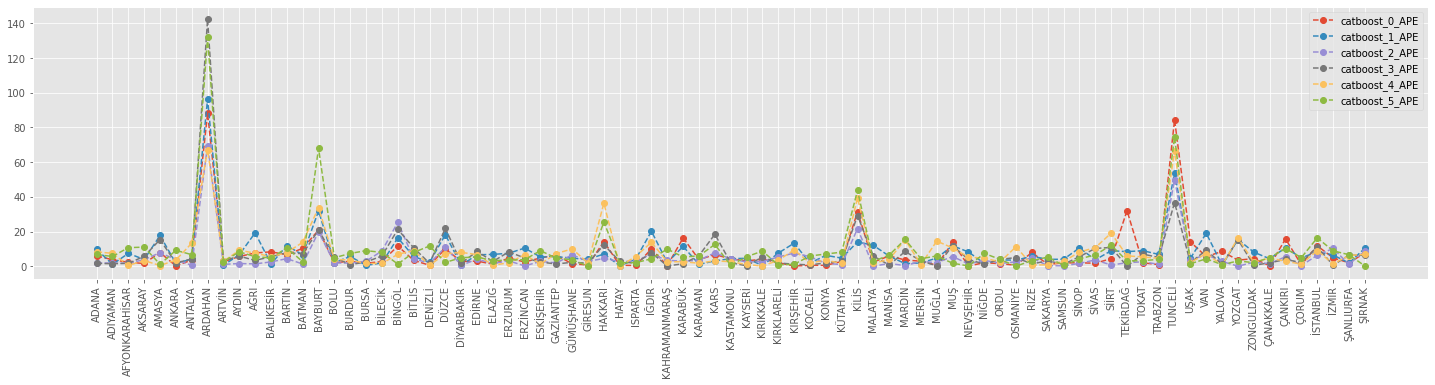

In [11]:
from src.utils.plotting import plot_metrics
plot_metrics(scoring_df.reset_index(), col_x="province", **col_ind_dict["catboost"])